# On Cloud N: Cloud Cover Detection Challenge
The [DrivenData](https://www.drivendata.org/competitions/83/cloud-cover/) challenge 

Thanks a lot to https://www.drivendata.co/blog/cloud-cover-benchmark/

## Overview
Satellite imagery is critical for a wide variety of applications from disaster management and recovery, to agriculture, to military intelligence. Clouds present a major obstacle for all of these use cases, and usually have to be identified and removed from a dataset before satellite imagery can be used. Improving methods of identifying clouds can unlock the potential of an unlimited range of satellite imagery use cases, enabling faster, more efficient, and more accurate image-based research.

The goal is to detect (to label) clouds in satellite imagery to remove cloud interference. The challenge uses publicly available satellite data from the [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2), which captures wide-swath, high-resolution, multi-spectral imaging. For each tile, data is separated into different bands of light across the full visible spectrum, near-infrared, and infrared light. Data is shared through [Microsoft's Planetary Computer](https://planetarycomputer.microsoft.com/).

In [1]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch

In [2]:
DATA_DIR = Path.cwd().parent.resolve() / 'drivenData_clouds/'
TRAIN_FEATURES = DATA_DIR / 'data/train_features'
TRAIN_LABELS = DATA_DIR / 'data/train_labels'

assert TRAIN_FEATURES.exists()

In [3]:
BANDS = ['B02', 'B03', 'B04', 'B08'] #different range of wavelengths (aka bands) blue/green/red/infrared

# Metadata
train_meta = pd.read_csv(DATA_DIR / 'train_metadata.csv')
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [4]:
train_meta[['chip_id', 'location', 'datetime']].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

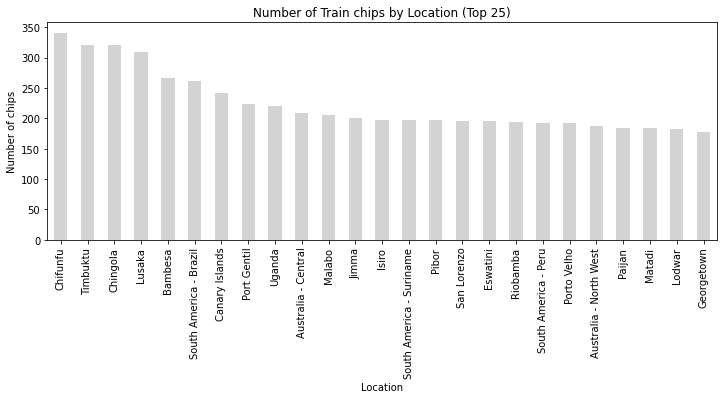

In [5]:
# graph of locations x number of chips
train_location_counts = (train_meta.groupby('location')['chip_id'].nunique().sort_values(ascending=False))
plt.figure(figsize=(12,4))
train_location_counts.head(25).plot(kind='bar', color='lightgray')
plt.xticks(rotation=90)
plt.xlabel('Location')
plt.ylabel('Number of chips')
plt.title('Number of Train chips by Location (Top 25)')
plt.show()

In [6]:
# time range
train_meta['datetime'] = pd.to_datetime(train_meta['datetime'])
train_meta['year'] = train_meta.datetime.dt.year
train_meta.groupby('year')[['chip_id']].nunique().sort_index().rename(columns={'chip_id' : 'chip_count'})

,chip_count
year,
2018,326
2019,1015
2020,10407


We can read this from problem description but to be sure let's find out the date range.

In [7]:
train_meta['datetime'].min(), train_meta['datetime'].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [8]:
chips_per_locationtime = (
    train_meta.groupby(['location','datetime'])[['chip_id']]
    .nunique()
    .sort_values(by='chip_id', ascending=False)
    .rename(columns={'chip_id' : 'chip_count'})
)

chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


## Images
Images are stored as GeoTiffs (512x512 resolution, one pixel is about 10m) covering the exact same area.

Sentinel-2 flies over the part of the Earth between 56° South (Cape Horn, South America) and 82.8° North (above Greenland), so our observations are all between these two latitudes. The chips are mostly from Africa, South America, and Australia.

In [22]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        print(feature_dir / df["chip_id"])
        #df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        assert df[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        assert df["label_path"].path.exists().all()

    return df


train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head()

TypeError: expected str, bytes or os.PathLike object, not Series

In [ ]:
example_chip = train_meta[train_meta["chip_id"] == "pbyl"]

display(example_chip)

In [ ]:
import rasterio
example_chip = example_chip.iloc[0]
with rasterio.open(example_chip["B04_path"]) as img:
    chip_metadata = img.meta
    img_array = img.read(1)

chip_metadata

In [ ]:
# what does the image array look like?
print("Image array shape:", img_array.shape)
img_array

In [ ]:
np.isnan(img_array).sum()

In [ ]:
plt.imshow(img_array)
plt.title(f"B04 band for chip id {example_chip.chip_id}")
plt.show()

### Coordinates

In [ ]:
# longitude/latitude of image's center
with rasterio.open(example_chip["B04_path"]) as img:
    lon, lat = img.lnglat()
    bounds = img.bounds
print(f"Longitude: {lon}, latitude: {lat}")

In [ ]:
bounds

There are different projections (crs atribute in metadata) in BoundingBox and Long/Lat. We can transform them with **pyproj** library

In [ ]:
import pyproj

In [ ]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

In [ ]:
left, bottom, right, top = lat_long_bounds(example_chip["B04_path"])
print(
    f"Image coordinates (lat, long):\nStart: ({left}, {bottom})"
    f"\nEnd: ({right}, {top})"
)

### True color image
We can also make a composition image from all three visible bands (blue/green/red) to visualize a high-quality, true color image. To show this image, we'll use the xarraz and xrspatial packages designed for Sentinel-2 satellite data.

In [ ]:
import xarray
import xrspatial.multispectral as ms

In [ ]:
def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])


def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir / chip_id
    red = get_xarray(chip_dir / "B04.tif")
    green = get_xarray(chip_dir / "B03.tif")
    blue = get_xarray(chip_dir / "B02.tif")

    return ms.true_color(r=red, g=green, b=blue)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
im = true_color_img(example_chip.chip_id)
ax.imshow(im)
plt.title(f"True color image for chip id {example_chip.chip_id}")

In [ ]:
def display_random_chip(random_state):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    random_chip = train_meta.sample(random_state=random_state).iloc[0]
    ax[0].imshow(true_color_img(random_chip.chip_id))
    ax[0].set_title(f"Chip {random_chip.chip_id}\n(Location: {random_chip.location})")
    label_im = Image.open(random_chip.label_path)
    ax[1].imshow(label_im)
    ax[1].set_title(f"Chip {random_chip.chip_id} label")

    plt.tight_layout()
    plt.show()

In [ ]:
display_random_chip(1)

In [ ]:
display_random_chip(9)

In [ ]:
display_random_chip(40)

### Split the Data
We split data into 1/3 validation and 2/3 training sets. 

There are some posibilities to change. Like changing splitting ratio (20/80 for example) or not to split by chips but by location. We can try

In [13]:
import random

In [14]:
random.seed(9) # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((3877, 5), (7871, 5))

In [15]:
# separate features from labels
feature_cols = ['chip_id'] + [f'{band}_path' for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[['chip_id', 'label_path']].copy()

train_x = train[feature_cols].copy()
train_y = train[['chip_id', 'label_path']].copy()

KeyError: "['B02_path', 'B03_path', 'B04_path', 'B08_path'] not in index"

In [ ]:
val_x.head()

In [ ]:
val_y.head()

## CODE EXECUTION
Let's sart with the basic neural network model (more specificaly publicly available convolutional neural network U-Net) using some of the standard libraries (PyTorch Lightning). (There is a lot of room for improvements).

U-Net was first designed to help process biomedical imaging and identify things like signs of disease. The basic structure is an encoder network followed by a decoder network. We'll use a pretrained backbone called ResNet34 as our encoder.


In [ ]:
# create benchmark_src folder
submission_dir = Path("benchmark_src")
if submission_dir.exists():
    shutil.rmtree(submission_dir)

submission_dir.mkdir(parents=True)

In [ ]:
%%file {submission_dir}/cloud_dataset.py
import numpy as np
import pandas as pd
import rasterio
import torch
from typing import Optional, List

class CloudDataset(torch.utils.data.Dataset):
    """
    Reads in images, transforms pixel values and serves a
    dictionary containing chip ids, image tensors and label
    mask (when available)
    """
    
    def __init__(
    self,
    x_paths: pd.DataFrame,
    bands: List[str],
    y_paths: Optional[pd.DataFrame] = None,
    transforms: Optional[list] = None
    ):
        """
        Instantiate the CloudDataset class.
        
        Args:
            x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be 
                a column for chip_id and a column with the path to the TIF for each of bands
            bands (list[str]): list of the bands included in the data
            y_paths (pd.DataFrame, optional): a dataframe with a row for each chip and columns for chip_id
                and the path to the label TIF with ground truth cloud cover
            transforms (list, optional): list of transforms to apply to the feature data (eg augmentations)
        """
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms
        self.bands = bands
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        # Loads an n-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        band_arrs = []
        for band in self.bands:
            with rasterio.open(img[f"{band}_path"]) as b:
                band_arr = b.read(1).astype("float32")
            band_arrs.append(bamd_arr)
        x_arr = np.stack(band_arrs, axis = -1)
        
        # Apply data augmentation, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2,0,1])
        
        # Prepare dictionary for item
        item = {"chip_id" : img.chip_id, "chip": x_arr}
        
        # Load label if available
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1).astype("float32")
            # Apply same data augmentation to the label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            item["label"] = y_arr
        
        return item

## CloudModel


In [12]:
%%file {submission_dir}/cloud_model.py
from typing import Optional, List

import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import torch

try:
    from cloud_dataset import CloudDataset
    from losses import intersection_over_union
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.losses import intersection_over_union
    
class CloudModel(pl.LighningModule):
    
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        hparams: dict = {},
    ):
        """
        Instantiate the CloudModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

        Args:
            bands (list[str]): Names of the bands provided for each chip
            x_train (pd.DataFrame, optional): a dataframe of the training features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_train (pd.DataFrame, optional): a dataframe of the training labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            x_val (pd.DataFrame, optional): a dataframe of the validation features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_val (pd.DataFrame, optional): a dataframe of the validation labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            hparams (dict, optional): Dictionary of additional modeling parameters.        
        """
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()
        
        # required
        self.bands = bands
        
        # optional modeling params
        self.backbone = self.hparams.get("backbone", "resnet34")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparmas.get("batch_size", 32)
        self.gpu = self.hparams.get("gpu", False)
        self.transform = None
        
        # Instantiante datasets, model, and trainer params if provided
        self.train_dataset = CloudDatset(
            x_paths = x_train,
            bands = self.bands,
            y_paths = y_train,
            transforms = self.transform
        )
        
        self.val_dataset = CloudDataset(
            x_path = v_val,
            bands = self.bands,
            y_paths = y_val,
            transforms = None
        )
        
        self.model = self._prepare_model()
        
    ## Required LightningModule methods ##
    
    def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)
    
    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number        
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train mus be specified when CloudModel is instantiated to run training"
            )
        
        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)
        
        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking = True), y.cuda(non_blocking=True)
            
        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1 #convert to int
        
        # Log batch IOU
        batch_iou = intersection_over_union(preds, y)
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou
    
    def train_dataloader(self):
        #Dataloader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            shuffle = True,
            pin_memory = True,
        )
    
    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]
    
    ## Convenience Methods ##
    
    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name = self.backbone,
            encoder_wights = self.weights,
            in_channels = 4,
            classes = 2,
        )
        
        if self.gpu:
            unet_model.cuda()
            
        return unet_model

Writing {submission_dir}/cloud_model.py


FileNotFoundError: [Errno 2] No such file or directory: '{submission_dir}/cloud_model.py'

In [ ]:
from benchmark_src.cloud_model import CloudModel

## Fit the Model

In [10]:
import warnings

warnings.filterwarnings("ignore")

In [11]:
# Set up pytorch_lightning.Trainer object
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
)

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='iou_epoch', mode='max', verbose=True)

early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor='iou_epoch',
    patience=(cloud_model.patience * 3),
    mode='max',
    vertbose=True,
)

trainer = pl.Trainer(
    gpus=None,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

NameError: name 'CloudModel' is not defined

In [ ]:
trainer.fit(model=cloud_model)

In [ ]:
submission_assets_dir = submission_dir / "assests"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

In [ ]:
%%file benchmark_src/main.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer

try:
    from cloud_dataset import CloudDataset
    from cloud_model import CloudModel
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.cloud_model import CloudModel
    
ROOT_DIRECTORY = Path('/codeexecution')
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / 'predictoins'
ASSETS_DIRECTORY = ROOT_DIRECTORY / 'assets'
DATA_DIRECTORY = ROOT_DIRECTORY / 'data'
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / 'test_features'

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ['TORCH_HOME'] = str(ASSETS_DIRECTORY / 'assets/torch')

def get_metadata(features_dir: os.PathLike, bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith('.')
    )
    
    for chip_id in chip_ids:
        chip_bands = [features_dir / chip_id / f"{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().rest_index().rename(columns={"index" : "chip_id"})

def make_predictoins(
    model: CloudModel,
    x_paths: pd.DataFrame,
    bands: List[str],
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    test_dataset = CloudDataset(x_path=x_paths, bands=bands)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size = model.batch_size,
        num_workers = model.num_workers,
        shuffle = False,
        pin_memory = True,
    )
    
    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["chip"]
        preds = model.forward[x]
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5).detach().numpy().astype('uint8')
        for chip_id, pred in zip(batc['chip_id'], preds):
            chip_pred_path = prediction_dir / f"{chip_id}.tif"
            chip_pred_im = Image.formarray(red)
            chip_pred_im.save(chip_pred_path)
            
def main():
    pass